In [1]:
import pandas as pd
import numpy as np

## Carregando os dados

### Informações sobre os estudates

In [2]:
df_students = pd.read_json('data/BASE B/students.json')
df_students['RegisteredDate'] = pd.to_datetime(df_students['RegisteredDate'])
df_students.head()

,Id,RegisteredDate,UniversityName,CourseName,State,SignupSource,City,StudentClient
0,12970655,2012-05-29 15:22:27.490,PUC-RIO,Administração,Rio de Janeiro,Email,NaN,NaN
1,59873654,2012-09-03 20:32:04.853,UFF,Direito do Trabalho e Segurança Social,Rio de Janeiro,Facebook,Rio de Janeiro,NaN
2,3664695,2012-09-10 20:26:30.253,UNB,Enfermagem,Distrito Federal,Facebook,NaN,NaN
3,15207697,2012-09-05 15:31:08.090,UERJ,Engenharia de Produção Mecânica,Rio de Janeiro,Facebook,Resende,NaN
4,36988693,2012-10-15 21:34:51.143,UFU,Engenharia Elétrica,NaN,Facebook,NaN,NaN


### Informações sobre os cancelamentos

In [120]:
df_cancellations = pd.read_json('data/BASE B/premium_cancellations.json')
df_cancellations['CancellationDate'] = pd.to_datetime(df_cancellations['CancellationDate'])
df_cancellations['year'] = df_cancellations['CancellationDate'].dt.year
df_cancellations['month'] = df_cancellations['CancellationDate'].dt.month
df_cancellations.head()

,StudentId,CancellationDate,year,month,day
0,34129668,2016-05-05 19:08:31.937,2016,5,1
1,34129668,2016-05-05 22:48:20.830,2016,5,1
2,82394932,2016-05-20 22:37:21.117,2016,5,1
3,82942835,2016-05-31 13:44:55.307,2016,5,1
4,85382416,2016-06-01 14:22:19.467,2016,6,1


#### Cancelamentos de 2016-05 até 2018-06
Como não sei se houve mais cancelamentos após 07/06/2018, vou limitar a análise até o fim do mês de maio/2018.

In [176]:
df_cancellations['CancellationDate'].describe()

count                            844
unique                           844
top       2018-03-26 21:00:21.361090
freq                               1
first     2016-05-05 19:08:31.937000
last      2018-06-07 14:44:20.650220
Name: CancellationDate, dtype: object

### Informações sobre as assinaturas do plano Premium

In [105]:
%%time
df_payments = pd.read_json('data/BASE B/premium_payments.json')
df_payments['PaymentDate'] = pd.to_datetime(df_payments['PaymentDate'])

df_payments['PlanDuration'] = pd.DateOffset(months=1)
df_payments.loc[df_payments['PlanType'] == 'Anual', 'PlanDuration'] = pd.DateOffset(years=1)

df_payments['ExpiryDate'] = df_payments['PaymentDate'] + df_payments['PlanDuration']

df_payments.head()

/home/lucas/miniconda3/envs/pdenv/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py:1151: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  PerformanceWarning,


CPU times: user 500 ms, sys: 15.6 ms, total: 516 ms
Wall time: 522 ms


,StudentId,PaymentDate,PlanType,PlanDuration,ExpiryDate
0,12970655,2017-05-26 22:25:03.000,Anual,<DateOffset: years=1>,2018-05-26 22:25:03.000
1,12970655,2018-05-26 10:05:28.000,Anual,<DateOffset: years=1>,2019-05-26 10:05:28.000
2,12970655,2016-07-21 19:57:57.717,Mensal,<DateOffset: months=1>,2016-08-21 19:57:57.717
3,12970655,2016-08-21 08:47:42.947,Mensal,<DateOffset: months=1>,2016-09-21 08:47:42.947
4,12970655,2016-09-21 08:54:06.270,Mensal,<DateOffset: months=1>,2016-10-21 08:54:06.270


### Assinaturas válidas no começo de cada mês

In [177]:
date_range = pd.date_range('2016-05-01', '2018-05-01', freq='MS')
df_amount_subscriptions = pd.Series([
    ((df_payments['ExpiryDate'] >= date) & (df_payments['PaymentDate'] < date)).sum() for date in date_range
],  index=date_range)
df_amount_subscriptions

2016-05-01      17
2016-06-01      24
2016-07-01      29
2016-08-01      38
2016-09-01      37
2016-10-01      39
2016-11-01      55
2016-12-01      82
2017-01-01      83
2017-02-01      73
2017-03-01      76
2017-04-01     123
2017-05-01     161
2017-06-01     187
2017-07-01     237
2017-08-01     213
2017-09-01     221
2017-10-01     289
2017-11-01     397
2017-12-01    1150
2018-01-01     974
2018-02-01     786
2018-03-01     707
2018-04-01     754
2018-05-01     948
Freq: MS, dtype: int64

### Cancelamentos por mês

In [179]:
df_cancel_by_month = df_cancellations.groupby(['year', 'month'])['CancellationDate'].count().reset_index()
df_cancel_by_month['day'] = 1 # just to align with the previous calculation's axis
df_cancel_by_month.index = pd.to_datetime(df_cancel_by_month[['year', 'month', 'day']])
df_cancel_by_month = df_cancel_by_month['CancellationDate'].asfreq('MS').fillna(0)[:'2018-05-01']
df_cancel_by_month

2016-05-01      4.0
2016-06-01      2.0
2016-07-01      5.0
2016-08-01      0.0
2016-09-01      2.0
2016-10-01      7.0
2016-11-01      7.0
2016-12-01      7.0
2017-01-01      4.0
2017-02-01      4.0
2017-03-01      6.0
2017-04-01      9.0
2017-05-01      9.0
2017-06-01     28.0
2017-07-01     25.0
2017-08-01     17.0
2017-09-01     19.0
2017-10-01     25.0
2017-11-01    117.0
2017-12-01    182.0
2018-01-01     98.0
2018-02-01     55.0
2018-03-01     57.0
2018-04-01     44.0
2018-05-01     89.0
Freq: MS, Name: CancellationDate, dtype: float64

### Churn Rate
Observa-se um aumento no pedido de cancelamentos no mês de novembro/2017 com a implementação do *Content Restriction*. Porém, de dezembro/2017 em diante, a quantidade de assinaturas aumentou consideravelmente e trouxe o *churn rate* para o patamar anterior à essa mudança, entre 5% e 15%.

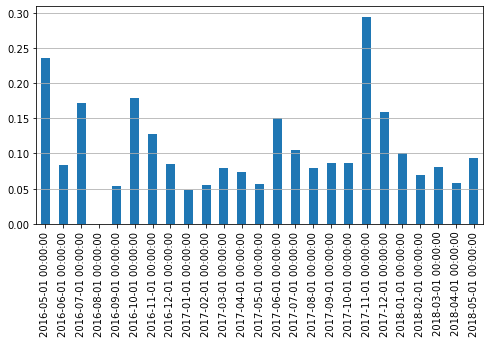

In [241]:
churn_rate = df_cancel_by_month / df_amount_subscriptions
ax = churn_rate.plot(kind='bar', figsize=(8,4))
ax.grid(True, axis='y')

## Lifetime Value (LTV)
Considerando o valor médio de R$29.90 mensais, observa-se uma queda expressiva do LTV no mês de Nov/2017. Contudo, o LTV foi restabelicido rapidamente com o aumento das assinaturas. 

Essa análise, porém, pode conter inconsistências com os valores reais devido a possíveis reajustes que ocorreram ao longo do tempo no preço da assinatura. Além disso, para uma análise mais precisa, a diferença entre os valores pagos pelos planos anual e mensal deveria ser considerada.

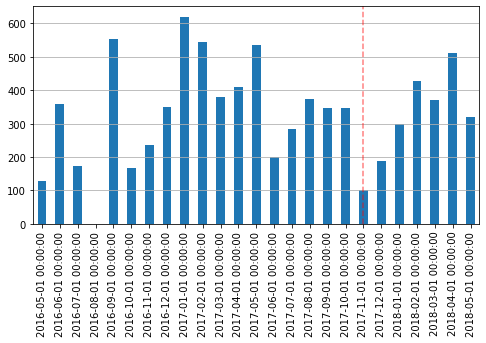

In [242]:
ltv = 29.9 / churn_rate
ax = ltv.plot(kind='bar', figsize=(8,4))
ax.axvline(18, color='r', linestyle='--', alpha=0.5) # Vertical line on Nov/2017
ax.grid(True, axis='y')

### LTV médio em 2017 antes de Nov/2017

In [239]:
print(f'R${ltv["2017-01-01":"2017-10-01"].mean().round(2)}')

R$403.95


### LTV médio após Nov/2017

In [203]:
print(f'R${ltv["2017-12-01":].mean().round(2)}')

R$352.52
